<a href="https://colab.research.google.com/github/LaboraDev/hackathon_one_flightOnTime/blob/main/pipeline_ds1_ds2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Semana 2 - DS1 (Pré-processamento), DS2 (Feature Engineering) e DS3 (Balanceamento e Preparação do Dataset para o Modelo)
--------------------------------------------------------------

Objetivo:
- DS1: criar um pipeline de pré-processamento unificado
        (limpeza, encoding, normalização) reutilizável.
- DS2: criar features temporais e features agregadas de atraso
        em um transformer próprio, também reutilizável.
- DS3: preparar o dataset para modelagem, incluindo:
        * Split estratificado em treino (~70%), validação (~10%) e teste (~20%)
        * Fit do pipeline de pré-processamento apenas no treino
        * Transformação aplicada em treino, validação e teste
        * Balanceamento do treino com SMOTE (oversampling) para classe minoritária

Ao final, salvamos:
- media_transformer_ds2.pkl  -> transformer de médias de atraso (DS2)
- preprocessor_ds1.pkl       -> pipeline de pré-processamento (DS1)
- X_train_processed.npy      -> dados de treino processados
- X_val_processed.npy        -> dados de validação processados
- X_test_processed.npy       -> dados de teste processados
- X_train_bal.npy            -> treino balanceado (SMOTE)
- y_train.npy                -> alvo do treino
- y_val.npy                  -> alvo da validação
- y_test.npy                 -> alvo do teste

"""

# ========================
# 1. Imports principais
# ========================

import os
import glob
import zipfile

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle


In [5]:
# =======================================================
# 2. Funções para carregar e preparar os dados (DS1)
# =======================================================

def baixar_e_extrair_dados(zip_path: str, extract_folder: str, file_id: str) -> None:
    """
    Baixa o arquivo .zip do Google Drive (se ainda não existir)
    e extrai o conteúdo para uma pasta.

    Parâmetros
    ----------
    zip_path : str
        Caminho onde o arquivo .zip será salvo.
    extract_folder : str
        Pasta onde os arquivos serão extraídos.
    file_id : str
        ID do arquivo no Google Drive.
    """
    import gdown  # import local para evitar erro se não for usar em outro ambiente

    if not os.path.exists(zip_path):
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, zip_path, quiet=False)

    if not os.path.exists(extract_folder):
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(extract_folder)


def carregar_vra(pasta: str,
                 padrao: str = "VRA_*.csv",
                 sep: str = ";",
                 encoding: str = "latin-1",
                 skiprows: int = 1) -> pd.DataFrame:
    """
    Carrega todos os arquivos VRA_*.csv de uma pasta e concatena
    em um único DataFrame.

    Retorna
    -------
    DataFrame com todos os voos concatenados.
    """
    caminho_busca = os.path.join(pasta, padrao)
    arquivos = sorted(glob.glob(caminho_busca))

    if not arquivos:
        raise FileNotFoundError(f"Nenhum arquivo encontrado em {caminho_busca}")

    dfs = []
    for arquivo in arquivos:
        df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
        dfs.append(df_temp)

    df_final = pd.concat(dfs, ignore_index=True)
    return df_final


def renomear_colunas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Padroniza nomes das colunas para snake_case em português simples.
    """
    df = df.copy()

    # Garante que acentos sejam lidos corretamente
    df.columns = [c.encode("latin1").decode("utf-8") for c in df.columns]

    mapa_colunas = {
        "ICAO Empresa Aérea": "empresa_aerea",
        "Número Voo": "numero_voo",
        "Código Autorização (DI)": "codigo_autorizacao_di",
        "Código Tipo Linha": "codigo_tipo_linha",
        "ICAO Aeródromo Origem": "aerodromo_origem",
        "ICAO Aeródromo Destino": "aerodromo_destino",
        "Partida Prevista": "partida_prevista",
        "Partida Real": "partida_real",
        "Chegada Prevista": "chegada_prevista",
        "Chegada Real": "chegada_real",
        "Situação Voo": "situacao_voo",
        "Código Justificativa": "codigo_justificativa",
    }

    df = df.rename(columns=mapa_colunas)
    return df


In [6]:
# =======================================================
# 3. Qualidade dos dados e criação do alvo (DS1)
# =======================================================

def criar_flags_qualidade(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria flags de qualidade para datas inválidas e períodos extremos.

    - Converte 'partida_prevista' e 'partida_real' para datetime.
    - Marca linhas com datas fora do período esperado.
    - Marca voos com diferença de horário muito alta (> 24h).
    """
    df = df.copy()

    df["partida_prevista"] = pd.to_datetime(
        df["partida_prevista"],
        format="%Y-%m-%d %H:%M:%S",
        errors="coerce",
    )
    df["partida_real"] = pd.to_datetime(
        df["partida_real"],
        format="%Y-%m-%d %H:%M:%S",
        errors="coerce",
    )

    df["flag_partida_prevista_ausente"] = df["partida_prevista"].isna()
    df["flag_partida_real_ausente"] = df["partida_real"].isna()
    df["flag_aerodromo_origem_ausente"] = df["aerodromo_origem"].isna()

    df["flag_data_partida_fora_periodo"] = (
        df["partida_prevista"].notna()
        & (
            (df["partida_prevista"].dt.year < 2021)
            | (df["partida_prevista"].dt.year > 2025)
        )
    )

    limite_horas = 24
    delta_h = (df["partida_real"] - df["partida_prevista"]).dt.total_seconds() / 3600
    df["flag_partida_muito_alto"] = (
        df["partida_prevista"].notna()
        & df["partida_real"].notna()
        & (delta_h.abs() > limite_horas)
    )

    return df


def criar_target_atrasado(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cria a coluna 'atrasado' (0 = pontual, 1 = atraso > 15 minutos).

    - Calcula 'atraso_partida_min' (diferença entre partida_real e partida_prevista).
    - Filtra linhas inválidas com base nas flags de qualidade.
    - Cria a coluna binária 'atrasado'.
    """
    df = df.copy()

    df["atraso_partida_min"] = (
        (df["partida_real"] - df["partida_prevista"]).dt.total_seconds() / 60
    )

    filtros_validos = (
        ~df["flag_partida_prevista_ausente"]
        & ~df["flag_partida_real_ausente"]
        & ~df["flag_data_partida_fora_periodo"]
        & ~df["flag_partida_muito_alto"]
    )

    df = df[filtros_validos].copy()
    df["atrasado"] = (df["atraso_partida_min"] > 15).astype(int)

    return df


In [7]:
# =======================================================
# 4. Amostragem estratificada (DS1)
# =======================================================

def criar_amostra_estratificada(
    df: pd.DataFrame,
    coluna_target: str = "atrasado",
    frac: float = 0.1,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Cria uma amostra estratificada simples, mantendo a proporção de atrasos.

    Parâmetros
    ----------
    frac : float
        Fração desejada (ex: 0.1 = 10% da base).
    """
    df_amostra, _ = train_test_split(
        df,
        test_size=1 - frac,
        random_state=random_state,
        stratify=df[coluna_target],
    )
    return df_amostra


In [8]:
# =======================================================
# 5. Features temporais (DS2)
# =======================================================

def criar_features_temporais(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hora_dia"] = df["partida_prevista"].dt.hour
    df["dia_semana"] = df["partida_prevista"].dt.dayofweek
    df["mes_ano"] = df["partida_prevista"].dt.month

    def classificar_periodo(hora: int) -> str:
        if 5 <= hora < 12: return "Manha"
        if 12 <= hora < 18: return "Tarde"
        if 18 <= hora < 22: return "Noite"
        return "Madrugada"

    df["periodo_dia"] = df["hora_dia"].apply(classificar_periodo)
    df["fim_de_semana"] = df["dia_semana"].isin([4, 5, 6]).astype(int)
    df["alta_temporada"] = df["mes_ano"].isin([7, 12]).astype(int)

    # --- NOVO (Requisito DS2): Transformações Log e Caps ---
    df["atraso_log"] = np.log1p(np.maximum(df["atraso_partida_min"], 0))
    df["atraso_capped"] = np.clip(df["atraso_partida_min"], 0, 120)

    return df



In [9]:
# =======================================================
# 6. Transformer de médias de atraso (DS2)
# =======================================================

class MediaAtrasoTransformer(BaseEstimator, TransformerMixin):
    """
    Cria três features numéricas com médias de atraso (em minutos):

    - media_atraso_empresa
    - media_atraso_origem
    - media_atraso_destino

    Importante:
    - Usa 'atraso_partida_min' apenas no treino (fit).
    - Na produção, o transformer reutiliza as médias aprendidas.
    """

    def __init__(self) -> None:
        self.medias_empresa = {}
        self.medias_origem = {}
        self.medias_destino = {}
        self.media_global = 0.0

    def fit(self, X: pd.DataFrame, y=None):
        # Calcula médias por empresa, origem e destino
        self.medias_empresa = (
            X.groupby("empresa_aerea")["atraso_partida_min"].mean().to_dict()
        )
        self.medias_origem = (
            X.groupby("aerodromo_origem")["atraso_partida_min"].mean().to_dict()
        )
        self.medias_destino = (
            X.groupby("aerodromo_destino")["atraso_partida_min"].mean().to_dict()
        )
        self.media_global = float(X["atraso_partida_min"].mean())
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        X["media_atraso_empresa"] = (
            X["empresa_aerea"].map(self.medias_empresa).fillna(self.media_global)
        )
        X["media_atraso_origem"] = (
            X["aerodromo_origem"].map(self.medias_origem).fillna(self.media_global)
        )
        X["media_atraso_destino"] = (
            X["aerodromo_destino"].map(self.medias_destino).fillna(self.media_global)
        )

        return X


In [10]:
# =======================================================
# 7. Definição de features e pipeline de pré-processamento
# =======================================================

# Nome da coluna alvo
TARGET_COL = "atrasado"

# Features originais (categorias de companhia/rota/tipo de linha)
FEATURES_ORIGINAIS = [
    "empresa_aerea",
    "aerodromo_origem",
    "aerodromo_destino",
    "codigo_tipo_linha",
]

# Features numéricas derivadas de tempo
NUMERIC_FEATURES_BASE = [
    "hora_dia",
    "dia_semana",
    "mes_ano",
    "fim_de_semana",
    "alta_temporada",
]

# Features categóricas finais
CATEGORICAL_FEATURES = [
    "empresa_aerea",
    "aerodromo_origem",
    "aerodromo_destino",
    "codigo_tipo_linha",
    "periodo_dia",
]


def montar_pipeline_preprocessamento():
    """
    Cria o pipeline de pré-processamento com:
    - Imputação de nulos para numéricas (mediana) + StandardScaler
    - Imputação de nulos para categóricas (DESCONHECIDO) + OrdinalEncoder
    """
    numeric_features_final = NUMERIC_FEATURES_BASE + [
        "media_atraso_empresa",
        "media_atraso_origem",
        "media_atraso_destino",
    ]

    numeric_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_pipeline = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="constant", fill_value="DESCONHECIDO"),
            ),
            (
                "encoder",
                OrdinalEncoder(
                    handle_unknown="use_encoded_value",
                    unknown_value=-1,
                ),
            ),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_features_final),
            ("cat", categorical_pipeline, CATEGORICAL_FEATURES),
        ],
        remainder="drop",
    )

    return preprocessor

import json

def realizar_analise_impacto(X_proc, y_val, nomes_colunas):
    """Gera o relatório de impacto das features (DS2)."""
    df_temp = pd.DataFrame(X_proc, columns=nomes_colunas)
    correlacao = df_temp.corrwith(pd.Series(y_val)).abs().sort_values(ascending=False)
    print("\n--- TOP 5 FEATURES POR IMPACTO ---")
    print(correlacao.head(5))

def salvar_documentacao_json(arquivo="documentacao_ds1_ds2.json"):
    """Cria o registro das features para o time de integração."""
    dados_doc = {
        "features": ["hora_dia", "mes_ano", "atraso_log", "atraso_capped", "media_atraso_empresa"],
        "target": "atrasado (1 para atraso > 15min)",
        "responsaveis": "Equipe DS1 e DS2"
    }
    with open(arquivo, "w") as f:
        json.dump(dados_doc, f, indent=4)


In [11]:
# =======================================================
# 8. Fluxo principal: carregar, transformar e salvar (DS1+DS2)
# =======================================================

# 8.1. Caminhos e parâmetros básicos
FILE_ID = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"  # mesmo ID do notebook original
ZIP_PATH = "dados_vra.zip"
EXTRACT_FOLDER = "dados_vra"
PASTA_VRA = os.path.join(EXTRACT_FOLDER, "dados_vra")

# 8.2. Carregar e preparar base
baixar_e_extrair_dados(ZIP_PATH, EXTRACT_FOLDER, FILE_ID);

df_raw = carregar_vra(pasta=PASTA_VRA)
df_raw = renomear_colunas(df_raw)
df_raw = criar_flags_qualidade(df_raw)
df_raw = criar_target_atrasado(df_raw)

# 8.3. Amostra estratificada para evitar uso de memória excessiva
df_sample = criar_amostra_estratificada(df_raw, coluna_target=TARGET_COL, frac=0.1)

# 8.4. Criar features temporais (DS2)
df_sample = criar_features_temporais(df_sample)
# df_sample = criar_feature_atraso_transformado(df_sample ) # Removido, pois a função não existe e as features já são criadas em criar_features_temporais

# 8.5. Aplicar transformer de médias (DS2)
media_transformer = MediaAtrasoTransformer()
df_sample = media_transformer.fit_transform(df_sample)

# 8.6. Separar X (features) e y (target)
colunas_features = (
    NUMERIC_FEATURES_BASE
    + CATEGORICAL_FEATURES
    + ["media_atraso_empresa", "media_atraso_origem", "media_atraso_destino"]
)

X = df_sample[colunas_features].copy()
y = df_sample[TARGET_COL].copy()

# 8.7. Montar e aplicar pipeline de pré-processamento (DS1)
preprocessor = montar_pipeline_preprocessamento()
X_processed = preprocessor.fit_transform(df_sample)

nomes_f = NUMERIC_FEATURES_BASE + ["media_atraso_empresa", "media_atraso_origem", "media_atraso_destino"] + CATEGORICAL_FEATURES
realizar_analise_impacto(X_processed, y.values, nomes_f)
salvar_documentacao_json() # Gera o documentacao_ds1_ds2.json

# 8.8. Salvar artefatos principais
with open("media_transformer_ds2.pkl", "wb") as f:
    pickle.dump(media_transformer, f)

with open("preprocessor_ds1.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

np.save("X_train_processed.npy", X_processed)
np.save("y_train.npy", y.values)

C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encodi


--- TOP 5 FEATURES POR IMPACTO ---
media_atraso_origem     0.130024
media_atraso_empresa    0.127043
codigo_tipo_linha       0.111690
media_atraso_destino    0.086280
hora_dia                0.077201
dtype: float64


In [12]:
# =======================================================
# 9. Resumo final do que foi feito (print)
# =======================================================

print("=" * 80)
print("RESUMO FINAL - DS1 (Pré-processamento) e DS2 (Feature Engineering)")
print("=" * 80)

print("\nDS1 - Pré-processamento unificado:")
print("- Carregamento e concatenação dos arquivos VRA_*.csv")
print("- Renomeação de colunas para nomes padronizados")
print("- Criação de flags de qualidade e filtro de linhas inválidas")
print("- Criação da coluna alvo 'atrasado' (0 = pontual, 1 = atraso > 15 min)")
print("- Amostra estratificada de ~10% da base para reduzir uso de memória")
print("- Pipeline de pré-processamento com:")
print("  * Imputação de nulos (numéricas: mediana, categóricas: 'DESCONHECIDO')")
print("  * Normalização (StandardScaler) para numéricas")
print("  * OrdinalEncoder para categóricas")

print("\nDS2 - Feature Engineering:")
print("- Criação de features temporais a partir de 'partida_prevista':")
print("  * hora_dia, dia_semana, mes_ano, periodo_dia, fim_de_semana, alta_temporada")
print("- Implementação do MediaAtrasoTransformer, que cria:")
print("  * media_atraso_empresa, media_atraso_origem, media_atraso_destino")
print("- Todas as features são compatíveis com uso posterior em API")

print("\nArquivos gerados:")
print("- media_transformer_ds2.pkl")
print("- preprocessor_ds1.pkl")
print("- X_train_processed.npy")
print("- y_train.npy")




RESUMO FINAL - DS1 (Pré-processamento) e DS2 (Feature Engineering)

DS1 - Pré-processamento unificado:
- Carregamento e concatenação dos arquivos VRA_*.csv
- Renomeação de colunas para nomes padronizados
- Criação de flags de qualidade e filtro de linhas inválidas
- Criação da coluna alvo 'atrasado' (0 = pontual, 1 = atraso > 15 min)
- Amostra estratificada de ~10% da base para reduzir uso de memória
- Pipeline de pré-processamento com:
  * Imputação de nulos (numéricas: mediana, categóricas: 'DESCONHECIDO')
  * Normalização (StandardScaler) para numéricas
  * OrdinalEncoder para categóricas

DS2 - Feature Engineering:
- Criação de features temporais a partir de 'partida_prevista':
  * hora_dia, dia_semana, mes_ano, periodo_dia, fim_de_semana, alta_temporada
- Implementação do MediaAtrasoTransformer, que cria:
  * media_atraso_empresa, media_atraso_origem, media_atraso_destino
- Todas as features são compatíveis com uso posterior em API

Arquivos gerados:
- media_transformer_ds2.pkl
- 

In [14]:
df_json = pd.read_json('documentacao_ds1_ds2.json')

In [17]:
df_json

,features,target,responsaveis
0,hora_dia,atrasado (1 para atraso > 15min),Equipe DS1 e DS2
1,mes_ano,atrasado (1 para atraso > 15min),Equipe DS1 e DS2
2,atraso_log,atrasado (1 para atraso > 15min),Equipe DS1 e DS2
3,atraso_capped,atrasado (1 para atraso > 15min),Equipe DS1 e DS2
4,media_atraso_empresa,atrasado (1 para atraso > 15min),Equipe DS1 e DS2


# **DS3 - Balanceamento e Preparação do Dataset para o Modelo**

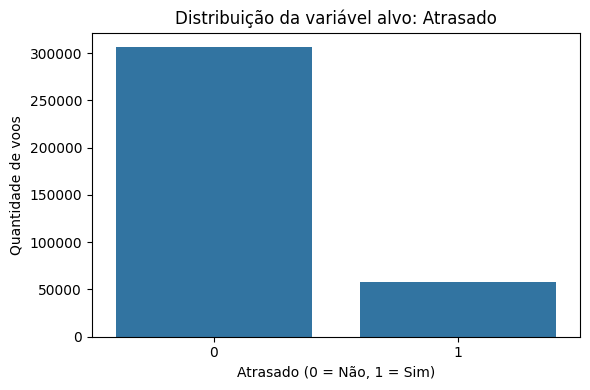

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_sample,
    x="atrasado"
)

plt.title("Distribuição da variável alvo: Atrasado")
plt.xlabel("Atrasado (0 = Não, 1 = Sim)")
plt.ylabel("Quantidade de voos")
plt.tight_layout()
plt.show()

In [30]:
def split_train_val_test(
    df:pd.DataFrame,
    target_col: str,
    test_size:float = 0.2,
    val_size:float = 0.1,
    random_state: int = 42,
    stratify: bool = True
):
    
    """
    Realiza split em treino, validação e teste.
    O split é estratificado pelo target para manter proporção de atrasos.
    """
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    stratify_y = y if stratify else None
    
    # Split treino + temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X,
        y,
        test_size=test_size + val_size,
        random_state=random_state,
        stratify=stratify_y,
    )
    
    # Split secundário: treino / validação
    val_relative_size = val_size / (1 - test_size)
    
    stratify_temp = y_temp if stratify else None

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp,
        y_temp,
        test_size=val_relative_size,
        random_state=random_state,
        stratify=stratify_temp,
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [31]:
def balancear_treino(X_train, y_train, metodo="smote", random_state=42):
    """
    Balanceia o conjunto de treino usando undersampling ou oversampling.
    
    Parâmetros:
    - X_train: np.array ou DataFrame
    - y_train: Series ou np.array
    - metodo: str, "smote" ou "undersample"
    
    Retorna:
    - X_train_bal, y_train_bal: arrays balanceados
    """
    if metodo == "smote":
        sampler = SMOTE(random_state=random_state)
    elif metodo == "undersample":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        raise ValueError("Método inválido. Use 'smote' ou 'undersample'.")

    X_train_bal, y_train_bal = sampler.fit_resample(X_train, y_train)
    return X_train_bal, y_train_bal

Alteração no ponto 8.6, 8.7 e 8.8 logo abaixo as alterações

In [32]:
# =======================================================
# 8. Fluxo principal: carregar, transformar e salvar (DS1+DS2)
# =======================================================

# 8.1. Caminhos e parâmetros básicos
FILE_ID = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"  # mesmo ID do notebook original
ZIP_PATH = "dados_vra.zip"
EXTRACT_FOLDER = "dados_vra"
PASTA_VRA = os.path.join(EXTRACT_FOLDER, "dados_vra")

# 8.2. Carregar e preparar base
baixar_e_extrair_dados(ZIP_PATH, EXTRACT_FOLDER, FILE_ID);

df_raw = carregar_vra(pasta=PASTA_VRA)
df_raw = renomear_colunas(df_raw)
df_raw = criar_flags_qualidade(df_raw)
df_raw = criar_target_atrasado(df_raw)

# 8.3. Amostra estratificada para evitar uso de memória excessiva
df_sample = criar_amostra_estratificada(df_raw, coluna_target=TARGET_COL, frac=0.1)

# 8.4. Criar features temporais (DS2)
df_sample = criar_features_temporais(df_sample)
# df_sample = criar_feature_atraso_transformado(df_sample ) # Removido, pois a função não existe e as features já são criadas em criar_features_temporais

# 8.5. Aplicar transformer de médias (DS2)
media_transformer = MediaAtrasoTransformer()
df_sample = media_transformer.fit_transform(df_sample)

# 8.6. Separar X (features) e y (target)
colunas_features = (
    NUMERIC_FEATURES_BASE
    + CATEGORICAL_FEATURES
    + ["media_atraso_empresa", "media_atraso_origem", "media_atraso_destino"]
)

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
) = split_train_val_test(
    df_sample[colunas_features + [TARGET_COL]],
    target_col=TARGET_COL,
)

# 8.7. Montar pipeline
preprocessor = montar_pipeline_preprocessamento()

# Fit APENAS no treino
X_train_proc = preprocessor.fit_transform(X_train)

# Transform nos demais conjuntos
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Oversampling com SMOTE
#X_train_bal, y_train_bal = balancear_treino(X_train_proc, y_train, metodo="smote")

# Ou undersampling:
X_train_bal, y_train_bal = balancear_treino(X_train_proc, y_train, metodo="undersample")

nomes_f = NUMERIC_FEATURES_BASE + ["media_atraso_empresa", "media_atraso_origem", "media_atraso_destino"] + CATEGORICAL_FEATURES
realizar_analise_impacto(X_processed, y.values, nomes_f)
salvar_documentacao_json() # Gera o documentacao_ds1_ds2.json

# 8.8. Salvar artefatos principais

# Dados processados
np.save("X_train_proc.npy", X_train_proc)
np.save("X_val_proc.npy", X_val_proc)
np.save("X_test_proc.npy", X_test_proc)
np.save("X_train_bal.npy", X_train_bal)
np.save("y_train_bal.npy", y_train_bal)

np.save("y_train.npy", y_train.values)
np.save("y_val.npy", y_val.values)
np.save("y_test.npy", y_test.values)

# Transformers
with open("preprocessor_ds1.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open("media_transformer_ds2.pkl", "wb") as f:
    pickle.dump(media_transformer, f)

C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encoding=encoding, skiprows=skiprows)
C:\Users\Enoque Mandlate\AppData\Local\Temp\ipykernel_8876\1969404820.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(arquivo, sep=sep, encodi


--- TOP 5 FEATURES POR IMPACTO ---
media_atraso_origem     0.130024
media_atraso_empresa    0.127043
codigo_tipo_linha       0.111690
media_atraso_destino    0.086280
hora_dia                0.077201
dtype: float64


In [ ]:
# =======================================================
# 9. Resumo final do que foi feito (print)
# =======================================================

print("=" * 80)
print("RESUMO FINAL - DS1 (Pré-processamento), DS2 (Feature Engineering) e DS3 (Balanceamento e Preparação do Dataset para o Modelo)")
print("=" * 80)

print("\nDS1 - Pré-processamento unificado:")
print("- Carregamento e concatenação dos arquivos VRA_*.csv")
print("- Renomeação de colunas para nomes padronizados")
print("- Criação de flags de qualidade e filtro de linhas inválidas")
print("- Criação da coluna alvo 'atrasado' (0 = pontual, 1 = atraso > 15 min)")
print("- Amostra estratificada de ~10% da base para reduzir uso de memória")
print("- Pipeline de pré-processamento com:")
print("  * Imputação de nulos (numéricas: mediana, categóricas: 'DESCONHECIDO')")
print("  * Normalização (StandardScaler) para numéricas")
print("  * OrdinalEncoder para categóricas")

print("\nDS2 - Feature Engineering:")
print("- Criação de features temporais a partir de 'partida_prevista':")
print("  * hora_dia, dia_semana, mes_ano, periodo_dia, fim_de_semana, alta_temporada")
print("- Implementação do MediaAtrasoTransformer, que cria:")
print("  * media_atraso_empresa, media_atraso_origem, media_atraso_destino")
print("- Todas as features são compatíveis com uso posterior em API")

print("\nDS3 - Balanceamento e Preparação para Modelagem:")
print("- Split estratificado em treino (~70%), validação (~10%) e teste (~20%)")
print("- Separação de X (features) e y (target) dentro da função split")
print("- Pipeline de pré-processamento aplicado:")
print("  * Fit apenas no treino")
print("  * Transform aplicado em treino, validação e teste")
print("- Balanceamento do conjunto de treino usando SMOTE (oversampling) para a classe minoritária 'atrasado'")
print("  * Classe majoritária preservada")
print("  * Evita perda de informação importante e melhora aprendizado do modelo")
print("- Validação e teste permanecem com distribuição original (~14% atrasos)")

print("\nArquivos gerados:")
print("- media_transformer_ds2.pkl")
print("- preprocessor_ds1.pkl")
print("- X_train_processed.npy")
print("- y_train.npy")
print("- X_train_proc.npy")
print("- X_val_proc.npy")
print("- y_val.npy")
print("- X_test_proc.npy")
print("- y_test.npy")
print("- X_train_bal.npy")
print("y_train_bal.npy")

RESUMO FINAL - DS1 (Pré-processamento) e DS2 (Feature Engineering)

DS1 - Pré-processamento unificado:
- Carregamento e concatenação dos arquivos VRA_*.csv
- Renomeação de colunas para nomes padronizados
- Criação de flags de qualidade e filtro de linhas inválidas
- Criação da coluna alvo 'atrasado' (0 = pontual, 1 = atraso > 15 min)
- Amostra estratificada de ~10% da base para reduzir uso de memória
- Pipeline de pré-processamento com:
  * Imputação de nulos (numéricas: mediana, categóricas: 'DESCONHECIDO')
  * Normalização (StandardScaler) para numéricas
  * OrdinalEncoder para categóricas

DS2 - Feature Engineering:
- Criação de features temporais a partir de 'partida_prevista':
  * hora_dia, dia_semana, mes_ano, periodo_dia, fim_de_semana, alta_temporada
- Implementação do MediaAtrasoTransformer, que cria:
  * media_atraso_empresa, media_atraso_origem, media_atraso_destino
- Todas as features são compatíveis com uso posterior em API

DS3 - Balanceamento e Preparação para Modelagem: